# 22 notebook #

This notebook implements the model training using only pure generated images to check whether the bias still occurs.

In [17]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

In [18]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array(
            [path + filename for filename in parameters["filename"].to_numpy()]
        )
        self.labels = parameters["epsilon"].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon * 1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)

In [19]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

In [20]:
main_dir = "../data/generated/"

In [21]:
main_params_dir = "../data/generated/"
blackbox_csv = pd.read_csv(main_params_dir + "blackbox_train.csv", index_col=False)
blackbox_csv["filename"] = "blackbox/" + blackbox_csv["filename"].astype(str)
blackbox_train, blackbox_valid = train_test_split(
    blackbox_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=blackbox_csv["epsilon"],
)

bubble_csv = pd.read_csv(main_params_dir + "bubble_train.csv", index_col=False)
bubble_csv["filename"] = "bubble/" + bubble_csv["filename"].astype(str)
bubble_train, bubble_valid = train_test_split(
    bubble_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=bubble_csv["epsilon"],
)

pizza_csv = pd.read_csv(main_params_dir + "pizza_train.csv", index_col=False)
pizza_csv["filename"] = "pizza/" + pizza_csv["filename"].astype(str)
pizza_train, pizza_valid = train_test_split(
    pizza_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=pizza_csv["epsilon"],
)

pure_csv = pd.read_csv(main_params_dir + "pure_train.csv", index_col=False)
pure_csv["filename"] = "pure/" + pure_csv["filename"].astype(str)
pure_train, pure_valid = train_test_split(
    pure_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=pure_csv["epsilon"],
)


# # laod test csv
blackbox_test = pd.read_csv(main_params_dir + "blackbox_test.csv", index_col=False)
blackbox_test["filename"] = "blackbox/" + blackbox_test["filename"].astype(str)

bubble_test = pd.read_csv(main_params_dir + "bubble_test.csv", index_col=False)
bubble_test["filename"] = "bubble/" + bubble_test["filename"].astype(str)

pizza_test = pd.read_csv(main_params_dir + "pizza_test.csv", index_col=False)
pizza_test["filename"] = "pizza/" + pizza_test["filename"].astype(str)

pure_test = pd.read_csv(main_params_dir + "pure_test.csv", index_col=False)
pure_test["filename"] = "pure/" + pure_test["filename"].astype(str)

In [22]:
DATASETS = {
    "blackbox": {
        "train": blackbox_train,
        "valid": blackbox_valid,
        "test": blackbox_test,
    },
    "bubble": {"train": bubble_train, "valid": bubble_valid, "test": bubble_test},
    "pizza": {"train": pizza_train, "valid": pizza_valid, "test": pizza_test},
    "pure": {"train": pure_train, "valid": pure_valid, "test": pure_test},
}

In [23]:
# combine all datasets
best_train = (
    pd.concat(
        [
            DATASETS["pure"]["train"],
            DATASETS["blackbox"]["train"],
            DATASETS["bubble"]["train"],
            DATASETS["pizza"]["train"],
        ]
    )
    .sample(frac=1, random_state=12)
    .reset_index(drop=True)
)

best_valid = (
    pd.concat(
        [
            DATASETS["pure"]["valid"],
            DATASETS["blackbox"]["valid"],
            DATASETS["bubble"]["valid"],
            DATASETS["pizza"]["valid"],
        ]
    )
    .sample(frac=1, random_state=12)
    .reset_index(drop=True)
)

In [24]:
train_dataset = ImageDataset(path=main_dir, parameters=best_train, transform=transform)
valid_dataset = ImageDataset(path=main_dir, parameters=best_valid, transform=transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0)

In [12]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

In [26]:
device = "cuda" if torch.cuda.is_available else "cpu"
lr = 1e-4
epochs = 10
print(device)

cuda


In [27]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [28]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.3), nn.ReLU(), nn.Linear(512, 1000)
)

model.fc = classifier

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=1, factor=0.9, min_lr=1e-5
)

In [31]:
min_valid_loss = np.inf
history = {"train_losses": [], "valid_losses": []}

model.cuda()

for epoch in range(epochs):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader):
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)

        loss = loss_fn(outputs, targets)

        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history["train_losses"].append(train_loss)

    model.eval()
    fin_targets = []
    fin_outputs = []
    valid_batch_losses = []
    with torch.no_grad():
        for data, labels in valid_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history["valid_losses"].append(valid_loss)

    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), "../models/22_notebook/best_steel_model.pth")
        min_valid_loss = valid_loss

    print(
        f"Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}"
    )
    scheduler.step(valid_loss)

    torch.save(model.state_dict(), "../models/22_notebook/final_steel_model.pth")

100%|██████████| 750/750 [02:52<00:00,  4.36it/s]


Epoch 0 		 Training Loss: 0.03128330408291706 		 Validation Loss: 0.007996983791836422


100%|██████████| 750/750 [02:38<00:00,  4.74it/s]


Epoch 1 		 Training Loss: 0.008376547222844375 		 Validation Loss: 0.007856657966144914


100%|██████████| 750/750 [02:38<00:00,  4.74it/s]


Epoch 2 		 Training Loss: 0.007654427354970108 		 Validation Loss: 0.006407590960405623


100%|██████████| 750/750 [02:35<00:00,  4.82it/s]


Epoch 3 		 Training Loss: 0.006396749695273385 		 Validation Loss: 0.005563615242662672


100%|██████████| 750/750 [02:33<00:00,  4.87it/s]


Epoch 4 		 Training Loss: 0.005758193132205039 		 Validation Loss: 0.00511120136428312


100%|██████████| 750/750 [02:35<00:00,  4.83it/s]


Epoch 5 		 Training Loss: 0.00536436912636578 		 Validation Loss: 0.004845815968661847


100%|██████████| 750/750 [02:33<00:00,  4.88it/s]


Epoch 6 		 Training Loss: 0.0050555778112417885 		 Validation Loss: 0.004552163297691225


100%|██████████| 750/750 [02:35<00:00,  4.82it/s]


Epoch 7 		 Training Loss: 0.00480974499537415 		 Validation Loss: 0.004452435336837218


100%|██████████| 750/750 [02:35<00:00,  4.81it/s]


Epoch 8 		 Training Loss: 0.0046165192075379195 		 Validation Loss: 0.004246567343943528


100%|██████████| 750/750 [02:36<00:00,  4.79it/s]


Epoch 9 		 Training Loss: 0.004437627720100807 		 Validation Loss: 0.004101055912909024


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import pandas as pd
import numpy as np

steel = pd.read_csv(
    "../data/results/best_steel_fourier_freq_model-raw_steel_predictions.csv"
)

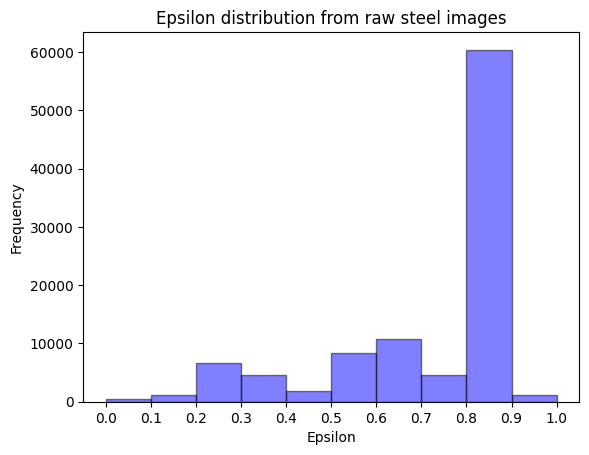

In [9]:
plt.hist(
    steel["epsilon"], bins=10, range=(0, 1), color="blue", alpha=0.5, edgecolor="black"
)
plt.title("Epsilon distribution from raw steel images")
plt.xlabel("Epsilon")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

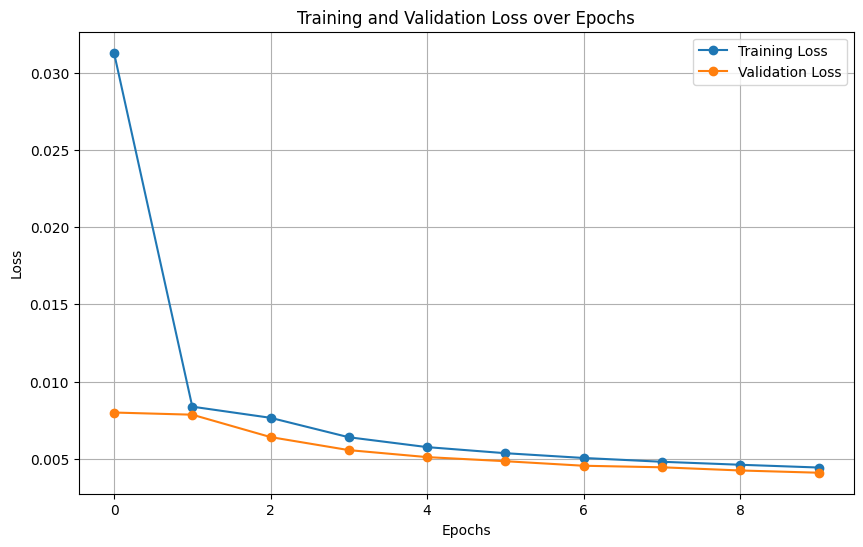

In [1]:
import matplotlib.pyplot as plt

# Extracted data from the logs
epochs = list(range(10))
training_loss = [
    0.03128330408291706,
    0.008376547222844375,
    0.007654427354970108,
    0.006396749695273385,
    0.005758193132205039,
    0.00536436912636578,
    0.0050555778112417885,
    0.00480974499537415,
    0.0046165192075379195,
    0.004437627720100807,
]

validation_loss = [
    0.007996983791836422,
    0.007856657966144914,
    0.006407590960405623,
    0.005563615242662672,
    0.00511120136428312,
    0.004845815968661847,
    0.004552163297691225,
    0.004452435336837218,
    0.004246567343943528,
    0.004101055912909024,
]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training Loss", marker="o")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()